# RL Notebook

In [11]:
# pip install pygame
# pip install gym==0.26.2
# pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests # compatible with gym 0.24+

In [1]:
import gym
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box
import random
import math 

import pygame
import stable_baselines3
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

from PIL import Image
import torch
import torchvision.transforms.functional as TF

# listing img files in directory data
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

# XY. Create custom environment

In [388]:
## import gym
## from gym import spaces
## import pygame
## import numpy as np
## import stable_baselines3

In [17]:
### class TestEnv(gym.Env):
###     metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
### 
###     def __init__(self, render_mode=None, size=5):
###         self.size = size  # The size of the square grid
###         self.window_size = 512  # The size of the PyGame window
### 
###         # Observations are dictionaries with the agent's and the target's location.
###         # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
###         self.observation_space = spaces.Dict(
###             {
###                 "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
###                 "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
###             }
###         )
### 
###         # We have 4 actions, corresponding to "right", "up", "left", "down"
###         self.action_space = spaces.Discrete(4)
### 
###         """
###         The following dictionary maps abstract actions from `self.action_space` to 
###         the direction we will walk in if that action is taken.
###         I.e. 0 corresponds to "right", 1 to "up" etc.
###         """
###         self._action_to_direction = {
###             0: np.array([1, 0]),
###             1: np.array([0, 1]),
###             2: np.array([-1, 0]),
###             3: np.array([0, -1]),
###         }
### 
###         assert render_mode is None or render_mode in self.metadata["render_modes"]
###         self.render_mode = render_mode
### 
###         """
###         If human-rendering is used, `self.window` will be a reference
###         to the window that we draw to. `self.clock` will be a clock that is used
###         to ensure that the environment is rendered at the correct framerate in
###         human-mode. They will remain `None` until human-mode is used for the
###         first time.
###         """
###         self.window = None
###         self.clock = None
###     
###     def _get_obs(self):
###         return {"agent": self._agent_location, "target": self._target_location}
###     
###     def _get_info(self):
###         return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
### 
###     def reset(self, seed=None, options=None):
###         # We need the following line to seed self.np_random
###         super().reset(seed=seed)
### 
###         # Choose the agent's location uniformly at random
###         self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
### 
###         # We will sample the target's location randomly until it does not coincide with the agent's location
###         self._target_location = self._agent_location
###         while np.array_equal(self._target_location, self._agent_location):
###             self._target_location = self.np_random.integers(
###                 0, self.size, size=2, dtype=int
###             )
### 
###         observation = self._get_obs()
###         info = self._get_info()
### 
###         if self.render_mode == "human":
###             self._render_frame()
### 
###         return observation, info
###     
###     def step(self, action):
###         # Map the action (element of {0,1,2,3}) to the direction we walk in
###         direction = self._action_to_direction[action]
###         # We use `np.clip` to make sure we don't leave the grid
###         self._agent_location = np.clip(
###             self._agent_location + direction, 0, self.size - 1
###         )
###         # An episode is done iff the agent has reached the target
###         terminated = np.array_equal(self._agent_location, self._target_location)
###         reward = 1 if terminated else 0  # Binary sparse rewards
###         observation = self._get_obs()
###         info = self._get_info()
### 
###         if self.render_mode == "human":
###             self._render_frame()
### 
###         return observation, reward, terminated, False, info
###     
###     def render(self):
###         if self.render_mode == "rgb_array":
###             return self._render_frame()
### 
###     def _render_frame(self):
###         if self.window is None and self.render_mode == "human":
###             pygame.init()
###             pygame.display.init()
###             self.window = pygame.display.set_mode((self.window_size, self.window_size))
###         if self.clock is None and self.render_mode == "human":
###             self.clock = pygame.time.Clock()
### 
###         canvas = pygame.Surface((self.window_size, self.window_size))
###         canvas.fill((255, 255, 255))
###         pix_square_size = (
###             self.window_size / self.size
###         )  # The size of a single grid square in pixels
### 
###         # First we draw the target
###         pygame.draw.rect(
###             canvas,
###             (255, 0, 0),
###             pygame.Rect(
###                 pix_square_size * self._target_location,
###                 (pix_square_size, pix_square_size),
###             ),
###         )
###         # Now we draw the agent
###         pygame.draw.circle(
###             canvas,
###             (0, 0, 255),
###             (self._agent_location + 0.5) * pix_square_size,
###             pix_square_size / 3,
###         )
### 
###         # Finally, add some gridlines
###         for x in range(self.size + 1):
###             pygame.draw.line(
###                 canvas,
###                 0,
###                 (0, pix_square_size * x),
###                 (self.window_size, pix_square_size * x),
###                 width=3,
###             )
###             pygame.draw.line(
###                 canvas,
###                 0,
###                 (pix_square_size * x, 0),
###                 (pix_square_size * x, self.window_size),
###                 width=3,
###             )
### 
###         if self.render_mode == "human":
###             # The following line copies our drawings from `canvas` to the visible window
###             self.window.blit(canvas, canvas.get_rect())
###             pygame.event.pump()
###             pygame.display.update()
### 
###             # We need to ensure that human-rendering occurs at the predefined framerate.
###             # The following line will automatically add a delay to keep the framerate stable.
###             self.clock.tick(self.metadata["render_fps"])
###         else:  # rgb_array
###             return np.transpose(
###                 np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
###             )
###         
###         def close(self):
###             if self.window is not None:
###                 pygame.display.quit()
###                 pygame.quit()
### 

In [18]:
### from gym.envs.registration import register
### 
### register(
###     id='gym_examples/TestEnv-v0',
###     entry_point='gym_examples.envs:TestEnv',
###     max_episode_steps=300,
### )

In [10]:
### env = gym.make('gym_examples/TestEnv-v0')

# 1. Load Synthetic Cities Pics

In [2]:
src = "../data/cadastralExport/"
onlyfiles = [f for f in listdir(src) if isfile(join(src, f))]
print(f"files in the folder: {len(onlyfiles)}")

files in the folder: 306


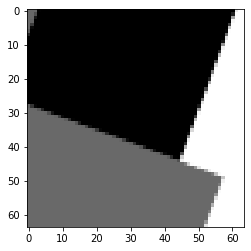

In [3]:
filesrc = random.choice(onlyfiles)
image = Image.open(src+filesrc)
x = TF.to_tensor(image)
# too large, let's take a cut
lim = 64
xSmall = torch.split(x[:3], lim, dim=1)[0].split(lim, dim=2)[0] # 4th channel is transparency
plt.imshow(xSmall.permute(*torch.arange(xSmall.ndim - 1, -1, -1)));

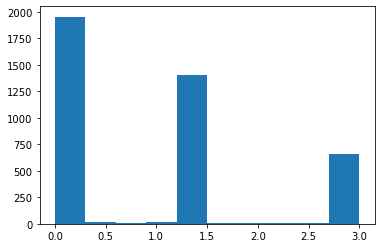

In [4]:
intensity = xSmall.sum(axis=0) 
plt.hist(intensity.flatten(start_dim=0).tolist());

In [5]:
def toRLScore(x):
    score = int
    if x < 0.5:
        # black -> building
        score = 10
    elif x > 2.5:
        # white -> road
        score = -1
    else:
        # neither building nor road
        score = -10
    return score

In [6]:
vfunc = np.vectorize(toRLScore)

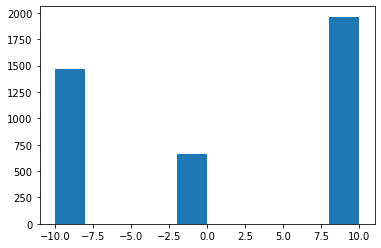

In [7]:
RLScore = vfunc(intensity)
plt.hist(RLScore.flatten());

All nicely packed in a function

In [225]:
def imgToScore(src, res):
    image = Image.open(src)
    x = TF.to_tensor(image)
    # top left corner, could be any place within the raster 
    xSmall = x[:3].split(res, dim=1)[0].split(res, dim=2)[0]
    xSmall= xSmall.permute(0,2,1) # getting x and y right
    intensity = xSmall.sum(axis=0)
    RLScore = vfunc(intensity)
    return xSmall, RLScore

In [237]:
res = 128
img = Image.open(filesrc)
size = img.size

In [238]:
size

(1280, 1280)

In [302]:
a = imgLoader(filesrc, 128)
print(f"size of the tensor: {a.X.size()}")
print(f"size of the not cut image: {a.ResxSmall.size()}")

size of the tensor: torch.Size([4, 1280, 1280])
size of the not cut image: torch.Size([4, 1280, 1280])


In [304]:
a.loadAndCut()
print(f"size of the cut image: {a.ResxSmall.size()}")

size of the cut image: torch.Size([3, 128, 128])


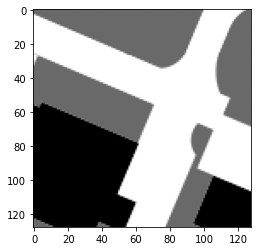

In [306]:
a.printCut()

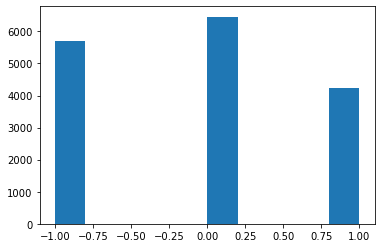

In [307]:
plt.hist(a.ResRLScore.flatten());

testing

file extracted: ../data/cadastralExport/CadastralX2687168Y1220810S250.png


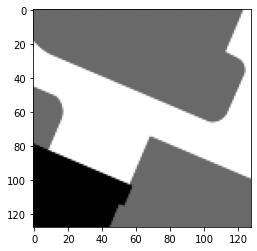

In [210]:
filesrc = src+random.choice(onlyfiles)
print(f"file extracted: {filesrc}")
imgSample, ScoreSample = imgToScore(filesrc, 128)
plt.imshow(imgSample.permute(2,1,0));

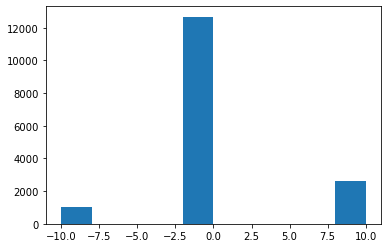

In [11]:
plt.hist(ScoreSample.flatten());

In [229]:
ScoreSample.flatten().size

16384

Conditions to position agent and target (if wished) everytime the environment is resetted

position of the agent: X:58, Y:60 | Reward: -1
position of the target: X:125, Y:60 | Reward: -1


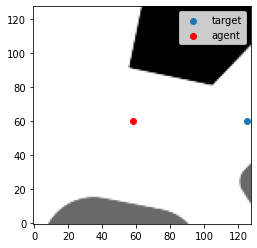

In [190]:
a = np.random.randint(0, 128, size=2, dtype=int)
t = np.random.randint(0, 128, size=2, dtype=int)

cond1 = np.array_equal(a,t)
cond2 = ScoreSample[t[0]][t[1]] != -1 # in a road ScoreSample.flatten().max()
cond3 = ScoreSample[a[0]][a[1]] != -1 # in a road ScoreSample.flatten().max()

while (cond1 or cond2 or cond3):
    t = np.random.randint(0, 128, size=2, dtype=int)
    a = np.random.randint(0, 128, size=2, dtype=int)
    cond1 = np.array_equal(a,t)
    cond2 = ScoreSample[t[0]][t[1]] != -1
    cond3 = ScoreSample[a[0]][a[1]] != -1

print(f"position of the agent: X:{a[0]}, Y:{a[1]} | Reward: {ScoreSample[a[1]][a[0]]}")
print(f"position of the target: X:{t[0]}, Y:{t[1]} | Reward: {ScoreSample[t[1]][t[0]]}")

plt.imshow(imgSample.permute(*torch.arange(imgSample.ndim - 1, -1, -1)), origin='lower')
plt.scatter(t[0], t[1], label='target')
plt.scatter(a[0], a[1], color='r', label = 'agent')
plt.legend();

# 2. Real City Environment 
based on https://www.gymlibrary.dev/content/environment_creation/

In [761]:
# this class loads and clips the image according to the target resolution, where there is less homogeneity

class imgLoader():
    def __init__(self, src, res):
        self.src = src
        self.res = res
        self.img = Image.open(self.src)
        self.size = self.img.size
        self.reps = [int(size[0]/self.res), int(size[1]/self.res)]
        self.scores = [1, 0, -1] # black, white, grey
        self.vfunc = np.vectorize(self.toRLScore)
        self.X = TF.to_tensor(self.img).permute(1,2,0)
        self.ResxSmall = self.X
        self.ResRLScore = np.zeros([self.res, self.res])
        
    def loadAndCut(self):
        # cut less homogeneous corner
        worseGini = 0
        for x in range(self.reps[0]):
            # print(f"X rep: {x}")
            for y in range(self.reps[1]):
                # print(f"Y rep: {y}")
                xSmall = self.X.split(self.res, dim=0)[x].split(self.res, dim=1)[y].split(3, dim=2)[0]
                intensity = xSmall.sum(axis=2)
                # print(f"intensitz: {intensity}")
                RLScore = self.vfunc(intensity)
                flatRLScore = RLScore.flatten()
                b = np.count_nonzero(flatRLScore == self.scores[0]) / flatRLScore.size
                r = np.count_nonzero(flatRLScore == self.scores[1]) / flatRLScore.size
                g = np.count_nonzero(flatRLScore == self.scores[2]) / flatRLScore.size
                Gini = 1 - (b**2 + r**2 + g**2)
                # print(f"single gini cohefficients: {b}, {r}, {g}")
                # print(f"gini cohefficient: {Gini} - Worse cohefficient: {worseGini}")
                if Gini > worseGini:
                    worseGini = Gini
                    # print(f"Worse Gini Score: {Gini}")
                    self.ResxSmall = xSmall
                    self.ResRLScore = RLScore.T
        return
    
    def toRLScore(self, x):
        score = int
        if x < 0.5:
            # black -> building
            score = self.scores[0]
        elif x > 2.5:
            # white -> road
            score = self.scores[1]
        else:
            # neither building nor road
            score = self.scores[2]
        return score
    
    def printCut(self):
        # plt.imshow(self.ResxSmall.permute(2,1,0));
        plt.imshow(self.ResxSmall);
    
    def printEntire(self):
        plt.imshow(self.X);

In [672]:
# this class collects and consolidates all the observations

class Observation():
    def __init__(self, radius):
        self.memory = list()
        self.coords = list()
    
    def check(self, observation: np.array) -> bool:
        obs_len = observation.size
        return obs_len == radius**2 # true if not close to the boarders of the pictures
    
    def consolidate(self, observation: np.array):
        # self.memory.extend([o for o in observation if (o[0], o[1]) not in self.coords])
        # print(f"observations: {observation}")
        for o in observation:
            # print(f"single observation : {o}")
            if ((o[0], o[1]) not in self.coords):
                self.coords.append((o[0], o[1])) 
                self.memory.append(o)
    
    def getLength(self) -> int:
        return len(self.memory)
    
    def getSample(self, batch_size) -> list:
        return random.sample(population=self.memory, k=batch_size)

In [32]:
class OLDRealCity(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, reward_map:np.ndarray, render_mode=None, size=5):
        self.reward_map = reward_map # map with the rewards on each position
        self.maxReward = self.reward_map.flatten().max()
        self.minReward = self.reward_map.flatten().min()
        self.size = self.reward_map.shape[0]  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(8)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([1, 1]),
            2: np.array([0, 1]),
            3: np.array([-1, 1]),
            4: np.array([-1, 0]),
            5: np.array([-1, -1]),
            6: np.array([0, -1]),
            7: np.array([1, -1]),
            8: np.array([0,0]) # exit function
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        # Both agent and target are required to stay on the street
        self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        
        RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
        
        cond1 = np.array_equal(self._target_location, self._agent_location)
        cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
        cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel
        while (cond1 & cond2 & cond3):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
            RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
            cond1 = np.array_equal(self._target_location, self._agent_location)
            cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
            cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        reward = 1000 if terminated else - np.sqrt(distance) + RewardAgent # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        # EXPECTED OUTPUTS BY STABLE BASELINE 3
        # obs, reward, done, info
        # EXPECTED OUTPUT IN STABLE BASELINE3 - PPO.learn
        # obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx]
        return observation, reward, terminated, False, info

In [933]:
class RealCity(gym.Env):
    # metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    def __init__(self, src, res, obsRadius=10, maxSteps=10000, render_mode=None):
        self.imgloader = imgLoader(src, res)
        self.imgloader.loadAndCut()
        self.reward_map = self.imgloader.ResRLScore # reward_map # map with the rewards on each position
        self.maxReward = self.reward_map.flatten().max()
        self.minReward = self.reward_map.flatten().min()
        self.size = self.reward_map.shape[0]  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.obsRadius = obsRadius # observation radius
        self.memory = Observation(self.obsRadius)
        self.presentStep = 0
        self.maxSteps = maxSteps #arbitrary number of step to end the game
        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "observation": spaces.Box(0, self.size - 1, shape=(2,), dtype=int), #initialized observation space
                # "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(8)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([1, 1]),
            2: np.array([0, 1]),
            3: np.array([-1, 1]),
            4: np.array([-1, 0]),
            5: np.array([-1, -1]),
            6: np.array([0, -1]),
            7: np.array([1, -1]),
            8: np.array([0,0]) # exit function
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        
    def _get_obs(self):
        return {"agent": self._agent_location, "observation": self.getObservation()}
    
    def _get_info(self):
        return {"observation": self.getObservation()}
    
    # def _get_info(self):
    #     return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, options=None):
        # print(seed)
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        # super().reset()
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        # Both agent and target are required to stay on the street
        self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        
        RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
        
        cond1 = np.array_equal(self._target_location, self._agent_location)
        cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
        cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel
        while (cond1 or cond2 or cond3):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
            RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
            cond1 = np.array_equal(self._target_location, self._agent_location)
            cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
            cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel

        # reset memory
        self.memory = Observation(self.obsRadius)
        
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def getMapValue(self, coords: list) -> int: 
        return(self.reward_map[coords[0], coords[1]])
    
    def getObservation(self):
        coords = self._agent_location.tolist()
        x = coords[0]
        y = coords[1]
        coords = [[coords[0], coords[1]]]
        x0y0 = [x, y, self.getMapValue([x, y])]
        newObservation = [x0y0]
        # all new coords
        candidates = []
        for increment in range(self.obsRadius+1):
            x1y0 = np.clip(np.array([x+increment, y]), 0, self.size - 1).tolist()
            x1y1 = np.clip(np.array([x+increment, y+increment]), 0, self.size - 1).tolist()
            x0y1 = np.clip(np.array([x, y+increment]), 0, self.size - 1).tolist()
            x_1y1 = np.clip(np.array([x-increment, y+increment]), 0, self.size - 1).tolist()
            x_1y0 = np.clip(np.array([x-increment, y]), 0, self.size - 1).tolist()
            x_1y_1 = np.clip(np.array([x-increment, y-increment]), 0, self.size - 1).tolist()
            x0y_1 = np.clip(np.array([x, y-increment]), 0, self.size - 1).tolist()
            x1y_1 = np.clip(np.array([x+increment, y-increment]), 0, self.size - 1).tolist()
            if len(candidates)==0:
                candidates = [x1y0, x1y1, x0y1, x_1y1, x_1y0, x_1y_1, x0y_1, x1y_1]
            else:
                candidates.extend([x1y0, x1y1, x0y1, x_1y1, x_1y0, x_1y_1, x0y_1, x1y_1])
        for c in candidates:
            if c not in coords:
                coords.append(c)
        # all rewards/pixel type in coords
        for cor in coords:
            # print(f"Real City Coordinates: {cor}")
            # print(f"Value at coordinates {cor}: {self.getMapValue(cor)}") 
            newValue = [cor[0], cor[1], self.getMapValue(cor)]
            newObservation.append(newValue)
            # print(f"Real City New Obs: {newObservation}")
            self.memory.consolidate(np.array(newObservation, dtype=object))
        observationBox = gym.spaces.Box(low=np.array([x-self.obsRadius, y-self.obsRadius]),
                                        high=np.array([x+self.obsRadius, y+self.obsRadius])
                                        )
        return observationBox
    
    def ObservationsToTensor(self):
        x = [el[0] for el in self.memory.memory]
        y = [el[1] for el in self.memory.memory]
        v = [el[2] for el in self.memory.memory]

        maxX = max(x)
        maxY = max(y)
        ShapeX = max(x) - min(x)
        ShapeY = max(y) - min(y)
        values = [1] # list.extend is only possible if the list is not empty 
        for l in range(min(x), max(x)):
            for s in range(min(y), max(y)):
                # print(f"X:{l}, Y:{s}")
                if (l, s) in self.memory.coords:
                    singleValue = self.getMapValue([l,s])
                    if singleValue == self.minReward:
                        values.extend([0.5, 0.5, 0.5]) # grey area
                    elif singleValue == RCenv.maxReward:
                        values.extend([0,0,0]) # building
                    else:
                        values.extend([1,1,1]) # road
                else:
                    values.extend([1,1,0])
        values.pop(0)
        tvalues = torch.FloatTensor(values)
        tvalues = tvalues.reshape(max(x)-min(x), max(y)-min(y),3)
        tvalues = tvalues.permute(1,0,2)
        return(tvalues)
    
    def ShuffleObservations(self, tensor):
        idx = torch.randperm(tensor.size(0))
        idy = torch.randperm(tensor.size(1))
        shuffled = tensor[idx,:,:]
        shuffled = shuffled[:,idy,:]
        return shuffled
    
    def isRealCity(self) -> bool:
        return
    
    def step(self, action):
        # update the step number
        self.presentStep+=1
        startingLocation = self._agent_location
        RewardAtStartingState = self.reward_map[startingLocation[0], startingLocation[1]]
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done after the designed step number is achieved
        terminated = self.presentStep >= self.maxSteps 
        # An episode is done if the agent has reached the target        
        # terminated = np.array_equal(self._agent_location, self._target_location)
        RewardAtEndState = self.reward_map[self._agent_location[0], self._agent_location[1]]
        distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        DifferenceReward = min(RewardAtStartingState - RewardAtEndState, RewardAtEndState - RewardAtStartingState)
        reward = 1000 if terminated else - np.sqrt(distance) + RewardAtEndState # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        return observation, DifferenceReward, terminated, False, info
    
    def printState(self):
        plt.imshow(self.imgloader.ResxSmall)
        try:
            plt.scatter([x[0] for x in self.memory.coords], [x[1] for x in self.memory.coords], color='r', alpha = 0.1, label ='observations')
            plt.scatter(self._agent_location[0], self._agent_location[1], label = 'agent', marker = "X", s=100)
            plt.legend()
        except:
            print("Environment not yet initialized, please Reset the environment")
        return
    
    def printObservations(self):
        c = []
        for el in self.memory.memory:
            if el[2] == self.minReward:
                c.append('silver')
            elif el[2] == self.maxReward:
                c.append('black')
            else:
                c.append('whitesmoke')
        x = [el[0] for el in self.memory.memory]
        y = [el[1] for el in self.memory.memory]
        plt.gca().invert_yaxis()
        plt.scatter(x, y , c=c)
        return
    
    def printObservationTensor(self, real:bool=True):
        tensor = self.ObservationsToTensor()
        if not real:
            tensor = self.ShuffleObservations(tensor)
        plt.gca().invert_yaxis()
        plt.imshow(tensor)
        return
        

In [141]:
# NOT UPDATED

class WalkingAgent(gym.Env):
    # metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, reward_map:np.ndarray, obsRadius=3, render_mode=None):
        self.reward_map = reward_map # map with the rewards on each position
        self.maxReward = self.reward_map.flatten().max()
        self.minReward = self.reward_map.flatten().min()
        self.size = self.reward_map.shape[0]  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        self.obsRadius = obsRadius # observation radius
        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "observation": spaces.Box(0, self.size - 1, shape=(2,), dtype=int), #initialized observation space
                # "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(8)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([1, 1]),
            2: np.array([0, 1]),
            3: np.array([-1, 1]),
            4: np.array([-1, 0]),
            5: np.array([-1, -1]),
            6: np.array([0, -1]),
            7: np.array([1, -1])
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        
    def _get_obs(self):
        return {"agent": self._agent_location, "observation": self.getObservation}
    
    def _get_info(self):
        return {"observation": self.getObservation()}
    
    # def _get_info(self):
    #     return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=8, options=None):
        print(seed)
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        # Both agent and target are required to stay on the street
        self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        
        RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
        
        cond1 = np.array_equal(self._target_location, self._agent_location)
        cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
        cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel
        while (cond1 & cond2 & cond3):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )
            RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
            RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
            cond1 = np.array_equal(self._target_location, self._agent_location)
            cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
            cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def getMapValue(self, coords: list) -> int: 
        return(self.reward_map[coords[0], coords[1]])
    
    def getObservation(self):
        coords = self._agent_location
        x = coords[0]
        y = coords[1]
        newObservation = []
        for increment in range(self.obsRadius):
            x0y0 = [x, y, self.getMapValue([x+increment, y])]
            x1y0 = [x+increment, y, self.getMapValue([x+increment, y])]
            x1y1 = [x+increment, y+increment, self.getMapValue([x+increment, y+increment])]
            x0y1 = [x, y+increment, self.getMapValue([x, y+increment])]
            x_1y1 = [x-increment, y+increment, self.getMapValue([x-increment, y+increment])]
            x_1y0 = [x-increment, y, self.getMapValue([x-increment, y])]
            x_1y_1 = [x-increment, y-increment, self.getMapValue([x-increment, y-increment])]
            x0y_1 = [x, y-increment, self.getMapValue([x, y-increment])]
            x1y_1 = [x+increment, y-increment, self.getMapValue([x+increment, y-increment])]
            if len(newObservation)>0:
                newObservation.extend([x0y0, x1y0, x1y1, x0y1, x_1y1, x_1y0, x_1y_1, x0y_1, x1y_1])
            else:
                newObservation = [x0y0, x1y0, x1y1, x0y1, x_1y1, x_1y0, x_1y_1, x0y_1, x1y_1]
        self.memory.consolidate(np.array(newObservation))
        observationBox = gym.spaces.Box(low=np.array([x-self.obsRadius, y-self.obsRadius]),
                                        high=np.array([x+self.obsRadius, y+self.obsRadius])
                                       )
        return observationBox
    
    def isRealCity(self) -> bool:
        return
    
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        reward = 1000 if terminated else - np.sqrt(distance) + RewardAgent # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        # EXPECTED OUTPUTS BY STABLE BASELINE 3
        # obs, reward, done, info
        # EXPECTED OUTPUT IN STABLE BASELINE3 - PPO.learn
        # obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx]
        return observation, reward, terminated, False, info

In [934]:
RCenv = RealCity(src=filesrc, res=128, obsRadius=3)
RCenv.reset()

({'agent': array([108,  74]),
  'observation': Box([105.  71.], [111.  77.], (2,), float32)},
 {'observation': Box([105.  71.], [111.  77.], (2,), float32)})

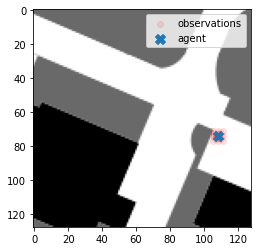

In [935]:
RCenv.printState()

In [941]:
for i in range(1000):
    RCenv.step(RCenv.action_space.sample())

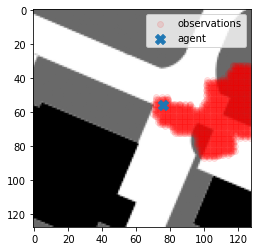

In [942]:
RCenv.printState()

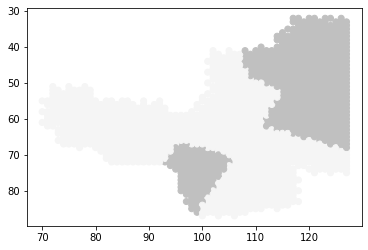

In [943]:
RCenv.printObservations()

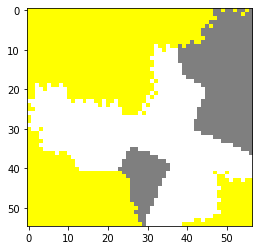

In [945]:
RCenv.printObservationTensor(real=True)

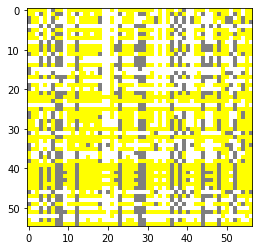

In [946]:
RCenv.printObservationTensor(real=False)

In [895]:
torch.randn(3, requires_grad=True)

tensor([0.7874, 2.4088, 0.1317], requires_grad=True)

In [955]:
T = RCenv.ObservationsToTensor()

In [957]:
T.flatten()

tensor([1., 1., 0.,  ..., 1., 1., 0.])

In [968]:
m = nn.Sigmoid()
loss = nn.BCELoss()
# target = torch.empty(3).random_(2)
real_label, fake_label = 1, 0
b_size = 1
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [970]:
target = torch.full((b_size,), real_label, dtype=torch.float, device=device)

In [971]:
target

tensor([1.], device='cuda:0')

In [976]:
loss = nn.BCELoss(reduction='mean')

In [975]:
m(T.flatten())

tensor([0.7311, 0.7311, 0.5000,  ..., 0.7311, 0.7311, 0.5000])

In [977]:
output = loss(m(T.flatten()), target)

ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([9405])) is deprecated. Please ensure they have the same size.

In [899]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()

In [949]:
torch.randn(3, requires_grad=True)

tensor([ 0.8357, -0.6758,  0.6533], requires_grad=True)

In [954]:
torch.empty(3).random_(2)

tensor([1., 1., 0.])

In [948]:
output

tensor(0.4864, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
tvalues.flatten()

tensor([0.5000, 0.5000, 0.5000,  ..., 1.0000, 1.0000, 0.0000])

In [892]:
nn.Sigmoid(tvalues.flatten())

TypeError: __init__() takes 1 positional argument but 2 were given

In [446]:
RCenv.reset()
steps = 10
for step in range(steps):
    state = RCenv.reset()
    terminated = False
    score = 0
    n_state = 0
    
    while not terminated:
        action = RCenv.action_space.sample()
        # observation, reward, terminated, False, info
        observation, reward, terminated, truncated, obs = RCenv.step(action)
        score += reward
        n_state += 1
        if n_state == steps:
            terminated = True
    print(f"Step: {step} | Steps: {n_state} | Agent: {observation['agent']} | Observation: {obs['observation']} | Score: {score}")

None
None
Step: 0 | Steps: 10 | Agent: [34 25] | Observation: Box([31. 22.], [37. 28.], (2,), float32) | Score: -108.07190401635323
None
Step: 1 | Steps: 10 | Agent: [69 77] | Observation: Box([66. 74.], [72. 80.], (2,), float32) | Score: -94.28102727315755
None
Step: 2 | Steps: 10 | Agent: [80 76] | Observation: Box([77. 73.], [83. 79.], (2,), float32) | Score: -98.33139883517079
None
Step: 3 | Steps: 10 | Agent: [62 63] | Observation: Box([59. 60.], [65. 66.], (2,), float32) | Score: -62.50522686200185
None
Step: 4 | Steps: 10 | Agent: [78 91] | Observation: Box([75. 88.], [81. 94.], (2,), float32) | Score: -31.66951120575565
None
Step: 5 | Steps: 10 | Agent: [104  49] | Observation: Box([101.  46.], [107.  52.], (2,), float32) | Score: -86.36612632766712
None
Step: 6 | Steps: 10 | Agent: [91 22] | Observation: Box([88. 19.], [94. 25.], (2,), float32) | Score: -73.82209552460918
None
Step: 7 | Steps: 10 | Agent: [99 23] | Observation: Box([96. 20.], [102.  26.], (2,), float32) | Scor

In [ ]:
plt.hist(RCenv.reward_map.flatten());

## 2.1 PPO with Stable Baseline
not working :-(

In [158]:
budget_pendulum = 4000

In [32]:
ppo_model = PPO("MultiInputPolicy", RCenv, verbose=0).learn(budget_pendulum)

In [33]:
obs = RCenv.reset()

In [34]:
#why not QLearning?! Q Learning is not worse than PPO in many cases -> Double Deep Q Networks!!!!!!! 

my 

In [ ]:
ppo_model.predict(obs)

Python 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


Observation Space.Space.item: odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])
In :  obs_as_tensor(observation, self.device)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In :  observation


array([{'agent': array([114,   2]), 'target': array([55, 23])},
       {'distance': 80.0}], dtype=object)

In :  list(observation)


[{'agent': array([114,   2]), 'target': array([55, 23])}, {'distance': 80.0}]

In :  key, items = observation.keys(), observation.values()


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In :  type(observation)


numpy.ndarray

In :  obs_as_tensor(observation, self.device)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In :  observation[0].values()


dict_values([array([114,   2]), array([55, 23])])

In :  array(observation[0].values())


NameError: name 'array' is not defined

In :  np.array(observation[0].values())


array(dict_values([array([114,   2]), array([55, 23])]), dtype=object)

In :  type(observation[0].values())


dict_values

In :  list(observation[0].values())


[array([114,   2]), array([55, 23])]

In :  t = list(observation[0].values())
In :  t.reshape((-1,) + self.observation_space[key].shape)


AttributeError: 'list' object has no attribute 'reshape'

In :  t = np.array(observation[0].values())
In :  t.reshape((-1,) + self.observation_space[key].shape)


NameError: name 'key' is not defined

In :  key


NameError: name 'key' is not defined

In :  observation_space


NameError: name 'observation_space' is not defined

In :  self.observation_space.shape
In :  self.observation_space.shape()


TypeError: 'NoneType' object is not callable

In :  self.observation_space


Dict('agent': Box(0, 127, (2,), int64), 'target': Box(0, 127, (2,), int64))

In [419]:
RCenv.step(RCenv.action_space.sample())

({'agent': array([113,   1]), 'target': array([55, 23])},
 -18.94427190999916,
 False,
 False,
 {'distance': 80.0})

In [423]:
RCenv.action_space.sample()

2

In [74]:
from stable_baselines3.common.env_checker import check_env

In [75]:
check_env(RCenv)

In [76]:
# env = YourEnv()
obs = RCenv.reset()
n_steps = 10
for _ in range(n_steps):
    # Random action
    action = RCenv.action_space.sample()
    obs, reward, done, truncated, info = RCenv.step(action)
    if done:
        print("DONE")
        obs = env.reset()

In [440]:
RCenv._get_obs()

{'agent': array([95, 81]), 'target': array([49, 57])}

In [441]:
obs = RCenv.reset()
# observation, Genv.step(Genv.action_space.sample())
# Genv.action_space.sample()

In [446]:
obs

({'agent': array([ 9, 77]), 'target': array([50, 28])}, {'distance': 90.0})

In [458]:
import gym
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box
import numpy as np
import random
import pygame
import stable_baselines3
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

from PIL import Image
import torch
import torchvision.transforms.functional as TF

# listing img files in directory data
from os import listdir
from os.path import isfile, join

import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
from stable_baselines3.common.env_util import make_vec_env

In [452]:
env = make_vec_env([RealCity(reward_map=ScoreSample)])

In [454]:
model = PPO("MultiInputPolicy", RCenv, verbose=1)
model.learn(total_timesteps=5000) # PPO("MultiInputPolicy", RCenv, verbose=0).learn(budget_pendulum)
model.save("RC_PPOModel")

del model # remove to demonstrate saving and loading

model = PPO.load("RC_PPOModel")

obs = RCenv.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 725  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 536         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014274165 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -0.00149    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.01e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00952    |
|    value_loss        

In [ ]:
model.predict(obs)

Python 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


Observation Space.Space.item: odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])
In :  dir()


['Dict',
 'GymEnv',
 'Iterable',
 'List',
 'Logger',
 'Optional',
 'Schedule',
 'SummaryWriter',
 'TensorDict',
 'TrainFreq',
 'TrainFrequencyUnit',
 'Tuple',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_non_vectorized',
 'check_for_correct_spaces',
 'check_shape_equal',
 'code',
 'compat_gym_seed',
 'configure',
 'configure_logger',
 'constant_fn',
 'deque',
 'explained_variance',
 'get_device',
 'get_latest_run_id',
 'get_linear_fn',
 'get_parameters_by_name',
 'get_schedule_fn',
 'get_system_info',
 'glob',
 'gym',
 'is_vectorized_box_observation',
 'is_vectorized_dict_observation',
 'is_vectorized_discrete_observation',
 'is_vectorized_multibinary_observation',
 'is_vectorized_multidiscrete_observation',
 'is_vectorized_observation',
 'key',
 'np',
 'obs_as_tensor',
 'observation',
 'observation_space',
 'os',
 'platform',
 'polyak_update',
 'random',
 're',
 'safe_mean',
 'sb3',
 'set_random_seed'

In :  observation


array([{'agent': array([111,  12]), 'target': array([ 8, 46])},
       {'distance': 137.0}], dtype=object)

In :  observation[0]


{'agent': array([111,  12]), 'target': array([ 8, 46])}

In :  key


'agent'

In :  observation[0][key]


array([111,  12])

In :  subspace


Box(0, 127, (2,), int64)

In :  subspace.shape


(2,)

In :  observation[0][key].shape != subspace.shape


False

In :  for key, subspace in observation_space.spaces.items():
...:      if observation[0][key].shape[1:] != subspace.shape:
...:          print(f"this key -> {key} is not vectorized")
...:  
this key -> agent is not vectorized
this key -> target is not vectorized
In :  observation[0][key].shape[1:]


()

In :  observation[0]['agent'].shape[1:]


()

In :  observation[0]['target'].shape[1:]


()

In :  observation[0]['agent'].shape


(2,)

In :  subspace.shape


(2,)

In :  observation_space.spaces.items()


odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])

In :  observation


array([{'agent': array([111,  12]), 'target': array([ 8, 46])},
       {'distance': 137.0}], dtype=object)

In :  observation_space


Dict('agent': Box(0, 127, (2,), int64), 'target': Box(0, 127, (2,), int64))

In :  quit()


NameError: name 'quit' is not defined

In :  exit()


NameError: name 'exit' is not defined


KeyboardInterrupt


In :  
In :  
In :  exit()


NameError: name 'exit' is not defined

In :  3+6


9


KeyboardInterrupt

KeyboardInterrupt


In [445]:
obs.observation_space

AttributeError: 'tuple' object has no attribute 'observation_space'

## 2.2 Example of DQN with Pytorch
Deep Q Learning, based on: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
plt.ion() # acitvates interactive plot

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [179]:
env = gym.make("CartPole-v1")

In [180]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [181]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # a deque (deck) is a list type container with fast pop/append on either ends

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(population=self.memory, k=batch_size) # return n=batch_size random samples from a list, string, set or tuple 

    def __len__(self):
        return len(self.memory)

In [182]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [190]:
status, info = RCenv.reset() # state, info = env.reset()
print(status)
print(info)

{'agent': array([ 5, 13]), 'target': array([69, 61])}
{'distance': 112.0}


In [191]:
# status must be consolidated in a single np.array with 4 elements agent x, agent y, target x, target y

In [196]:
[k for k in state.keys()]

SyntaxError: invalid syntax (1273982024.py, line 1)

In [213]:
r = 
r

array([ 5, 13, 69, 61])

In [188]:
s, i = env.reset()
print(f"status length: {len(s)}, status: {s}")

status length: 4, status: [ 0.02315129 -0.04100154 -0.02364553 -0.01697979]


In [214]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = RCenv.action_space.n # n_actions = env.action_space.n
# Get the number of state observations
state, info = RCenv.reset() # state, info = env.reset()
state = np.array(list(state.values())).flatten() # agent x, agent y, target x, target y in a flat array
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        return torch.tensor([[RCenv.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [215]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [216]:
if torch.cuda.is_available():
    num_episodes = 60
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = RCenv.reset() # state, info = env.reset()
    # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = torch.tensor(state['agent'], dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = RCenv.step(action.item()) # observation, reward, terminated, truncated, _ = env.step(action.item()) 
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor(observation['agent'], dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x128)

In [138]:
env.step(env.action_space.sample())

(array([-0.00808663,  0.19616404, -0.01706432, -0.2940259 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [139]:
RCenv.step(action.item())

({'agent': array([111,  10]), 'target': array([ 8, 46])},
 -1.7898261225515952,
 False,
 False,
 {'distance': 139.0})

# 3 Shower Example
based on the video: https://www.youtube.com/watch?v=bD6V3rcr_54

In [372]:
class ShowerEnv(Env):
    
    def __init__(self):
        # actions
        self.action_space = Discrete(3)
        # state
        self.state = 38 + random.randint(-3,3)
        # observation
        self.observation_space = Box(low = np.array([0]), high = np.array([100]))
        # episodes
        self.episodes_length = 60
        
    def step(self, action):
        reward = 0
        self.state += action - 1
        self.episodes_length -= 1
        if self.state >=37 and self.state <= 39:
            reward += 1
        else:
            reward -= 1
        # check if the time is up 
        if self.episodes_length <= 0:
            done = True
        else:
            done = False
        # Apply temperature noise
        self.state += random.randint(-1,1)
        
        # placeholder for info
        info = spaces.Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
        
        return self.state, reward, done, info
        
    def render(self):
        # implement visualization
        pass
    def reset(self):
        # reset
        self.state = 38 + random.randint(-3,3)
        self.episodes_length = 60
        return self.state

In [373]:
ShowerEnv = ShowerEnv()

/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [377]:
ShowerEnv.observation_space.sample()

array([74.26477], dtype=float32)

In [379]:
ShowerEnv.step(ShowerEnv.action_space.sample())

(40, -1, False, Box(-1.0, 2.0, (3, 4), float32))

In [381]:
episodes = 10
for episode in range(episodes):
    state = ShowerEnv.reset()
    done = False
    score = 0
    
    while not done:
        action = ShowerEnv.action_space.sample()
        n_state, reward, done, info = ShowerEnv.step(action)
        score += reward
    print('Episode: {} | State: {} | Action: {} | Score: {}'.format(episode, n_state, action, score))

Episode: 0 | State: 41 | Action: 2 | Score: -46
Episode: 1 | State: 32 | Action: 0 | Score: -6
Episode: 2 | State: 45 | Action: 1 | Score: -48
Episode: 3 | State: 37 | Action: 0 | Score: 12
Episode: 4 | State: 35 | Action: 0 | Score: -14
Episode: 5 | State: 35 | Action: 2 | Score: -44
Episode: 6 | State: 33 | Action: 0 | Score: -46
Episode: 7 | State: 50 | Action: 1 | Score: -48
Episode: 8 | State: 30 | Action: 0 | Score: -18
Episode: 9 | State: 36 | Action: 1 | Score: -16


## RL on "shower environment"

In [382]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

In [76]:
# pip install stable_baselines3

In [383]:
# 4000 training timesteps
budget_pendulum = 4000

In [385]:
ppo_model = PPO("MlpPolicy", ShowerEnv, verbose=0).learn(budget_pendulum)

TypeError: cannot unpack non-iterable int object

In [ ]:
ppo_model.learn(total_timesteps=1000)

In [ ]:
obs = env.reset()

In [ ]:
while True:
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = env.step(action)

In [96]:
env.step(action)

(37, 1, False, {})

In [386]:
import gym
env = gym.make("LunarLander-v2", render_mode="human")
env.action_space.seed(42)

observation, info = env.reset(seed=42)

for _ in range(1000):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset()

env.close()

DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`